In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [2]:
import warnings
warnings.filterwarnings('ignore')

## Import libraries


In [3]:
import pandas as pd
from scipy.stats import pearsonr
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from statsmodels.stats.multitest import multipletests
from scipy.stats import mannwhitneyu
from scipy.stats import chi2_contingency
from scipy import stats
from scipy.stats import skew,norm
from sklearn.cluster import KMeans
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
! pip install shap
import shap

In [4]:
#file_path = "/content/drive/MyDrive/Student_performance_data _.csv"
file_path = "/content/drive/MyDrive/Student_performance_data _.csv"
df= pd.read_csv(file_path)
df.head()


,StudentID,Age,Gender,Ethnicity,ParentalEducation,StudyTimeWeekly,Absences,Tutoring,ParentalSupport,Extracurricular,Sports,Music,Volunteering,GPA,GradeClass
0,1001,17,1,0,2,19.833723,7,1,2,0,0,1,0,2.929196,2.0
1,1002,18,0,0,1,15.408756,0,0,1,0,0,0,0,3.042915,1.0
2,1003,15,0,2,3,4.210570,26,0,2,0,0,0,0,0.112602,4.0
3,1004,17,1,0,3,10.028829,14,0,3,1,0,0,0,2.054218,3.0
4,1005,17,1,0,2,4.672495,17,1,3,0,0,0,0,1.288061,4.0


In [5]:
df_original= df.copy()
df_original= df_original.drop(columns='GPA')
one_hot_encoded = pd.get_dummies(df['Ethnicity'], prefix='Ethnicity').astype(int)
df_original = pd.concat([df_original, one_hot_encoded], axis=1)
df_original = df_original.drop('Ethnicity', axis=1)
df_original['is_male'] = df_original['Gender'].apply(lambda x: 1 if x == 0 else 0)
df_original['is_female'] = df_original['Gender'].apply(lambda x: 1 if x == 1 else 0)
df_original = df_original.drop('Gender', axis=1)
if df_original["StudentID"].nunique()== len(df_original):
  print("StudentID is unique feature for each row- dropping this column")
  df_original= df_original.drop(columns="StudentID")
else:
  print("StudentID is not unique, keeping it")

StudentID is unique feature for each row- dropping this column


## EDA

Check columns types

In [6]:
df.dtypes

,0
StudentID,int64
Age,int64
Gender,int64
Ethnicity,int64
ParentalEducation,int64
StudyTimeWeekly,float64
Absences,int64
Tutoring,int64
ParentalSupport,int64
Extracurricular,int64


As the classification column,GradeClass, is directly affected by the GPA, we will remove the GPA column from the data.

In [7]:
df= df.drop(columns='GPA')


The column "Ethnicity" is categorical, for this reason we will one encode this column.
Moreover, we added one more column named "is_male" where 1 indicates yes otherwise 0 and convert the "Gender" column name to "is_female".
This way we can describe out data better, without giving any preferance to any group.

Handling Categorical columns by encode them to one hot

In [8]:
one_hot_encoded = pd.get_dummies(df['Ethnicity'], prefix='Ethnicity').astype(int)
df = pd.concat([df, one_hot_encoded], axis=1)
df = df.drop('Ethnicity', axis=1)
df['is_male'] = df['Gender'].apply(lambda x: 1 if x == 0 else 0)
df['is_female'] = df['Gender'].apply(lambda x: 1 if x == 1 else 0)
df = df.drop('Gender', axis=1)

Checking if "StudentID" is unique feature, if so we will drop it

In [9]:
if df["StudentID"].nunique()== len(df):
  print("StudentID is unique feature for each row- dropping this column")
  df= df.drop(columns="StudentID")
else:
  print("StudentID is not unique, keeping it")

StudentID is unique feature for each row- dropping this column


Checking for missing values in each column

In [10]:
missing_values_count = df.isnull().sum()
print(missing_values_count)

Age                  0
ParentalEducation    0
StudyTimeWeekly      0
Absences             0
Tutoring             0
ParentalSupport      0
Extracurricular      0
Sports               0
Music                0
Volunteering         0
GradeClass           0
Ethnicity_0          0
Ethnicity_1          0
Ethnicity_2          0
Ethnicity_3          0
is_male              0
is_female            0
dtype: int64


Checking for duplicates rows- if so we will keep just the first occurrence

In [11]:
# Identifying duplicate rows
duplicates = df.duplicated()
duplicate_count = duplicates.sum()
print("Number of duplicate rows:", duplicate_count)

# Drop duplicate rows, keeping the first occurrence
df = df.drop_duplicates()

Number of duplicate rows: 0


Histograms of each column

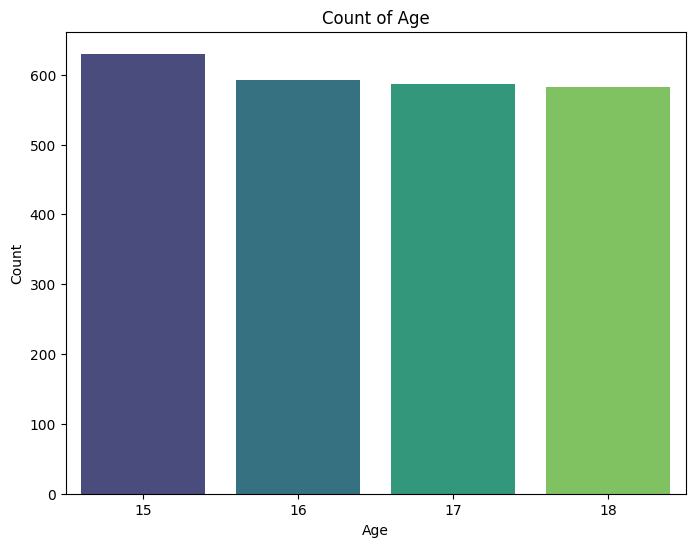

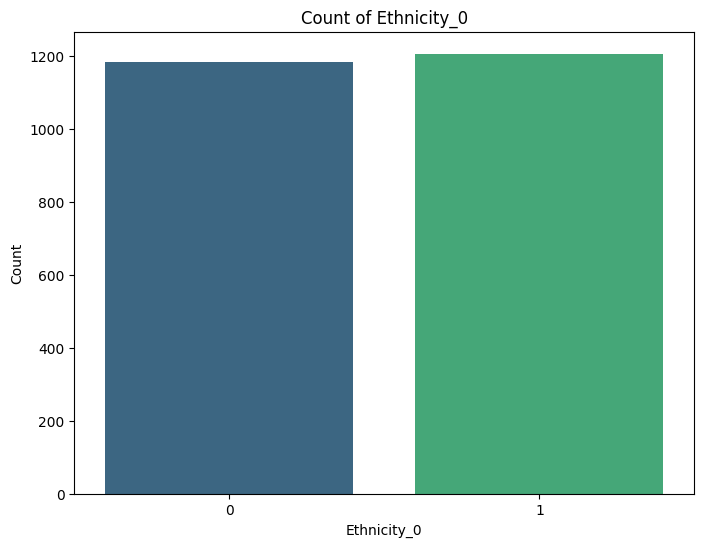

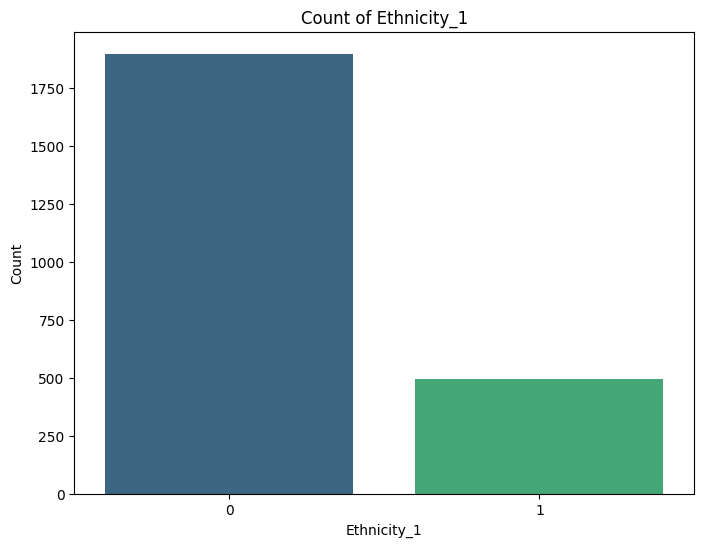

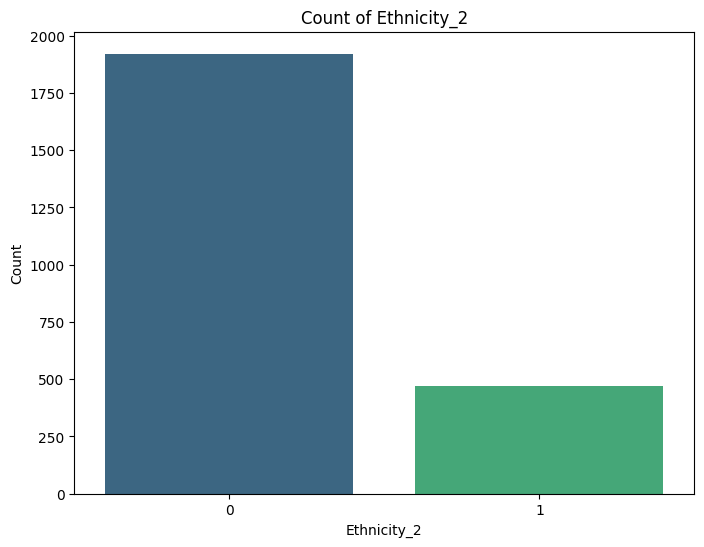

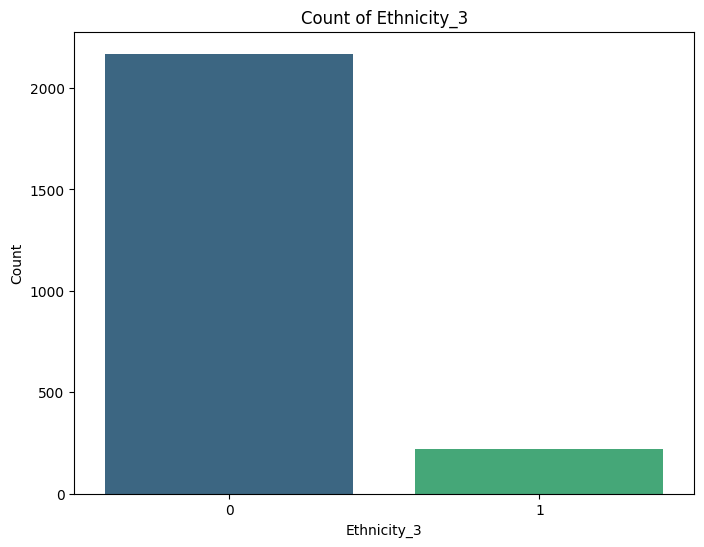

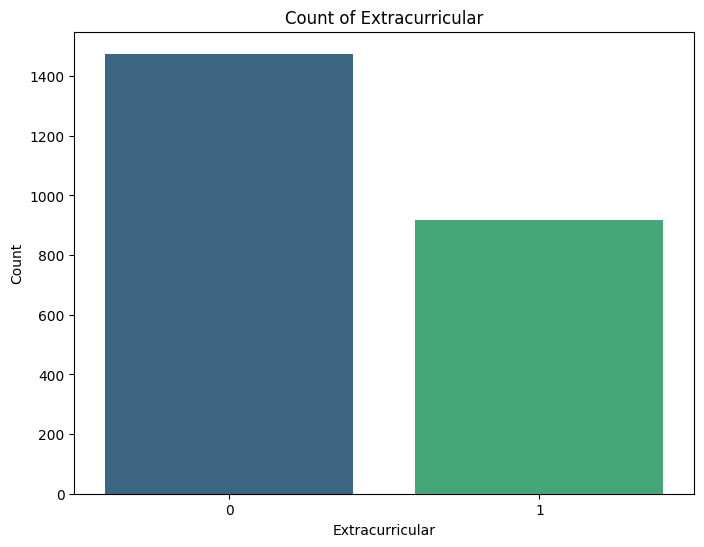

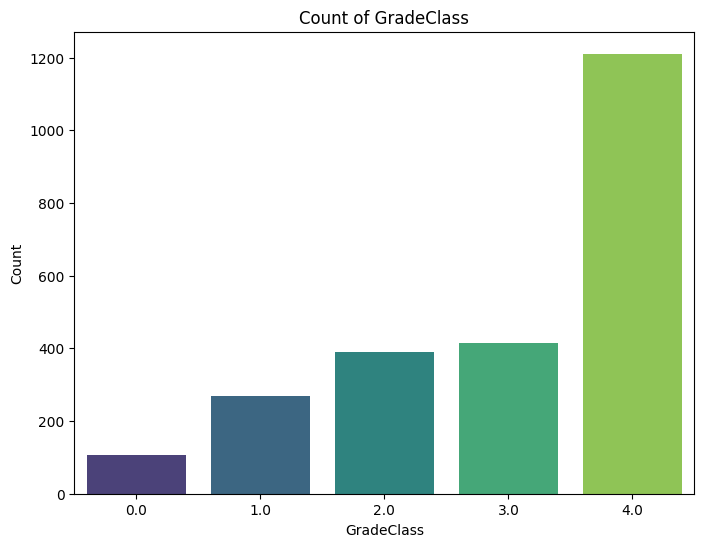

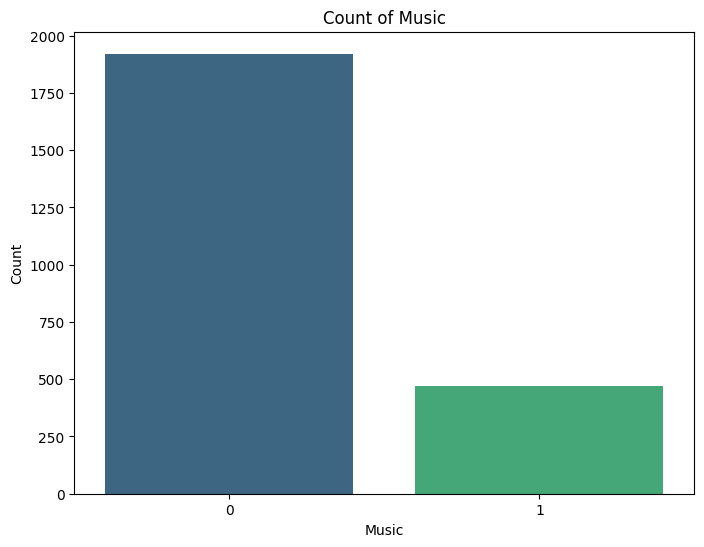

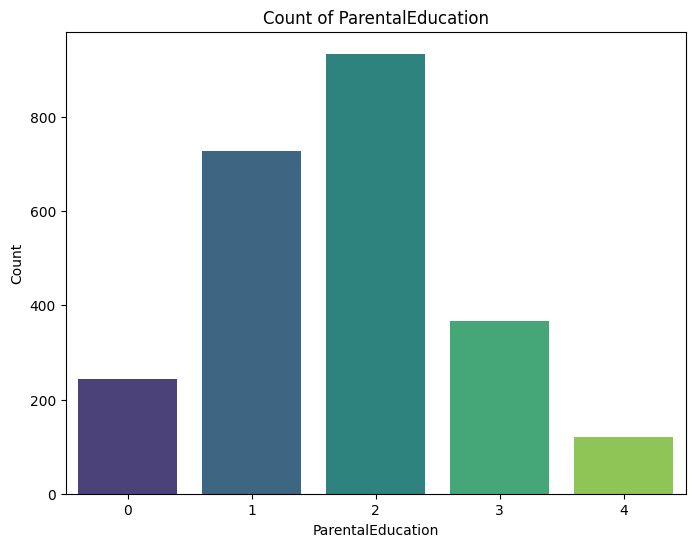

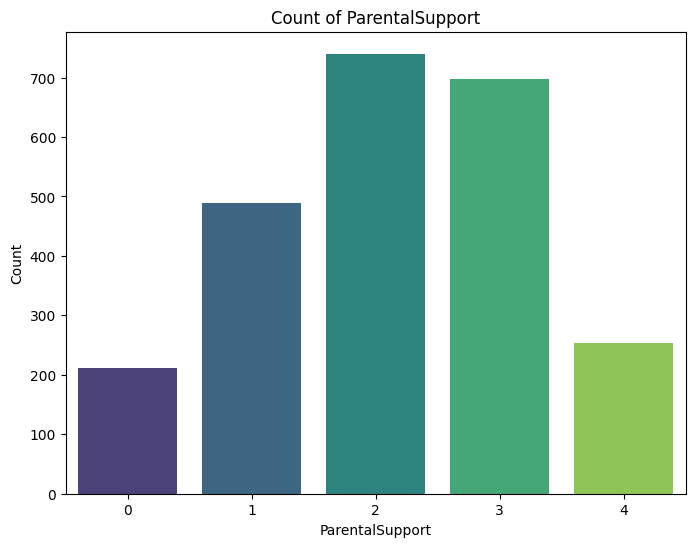

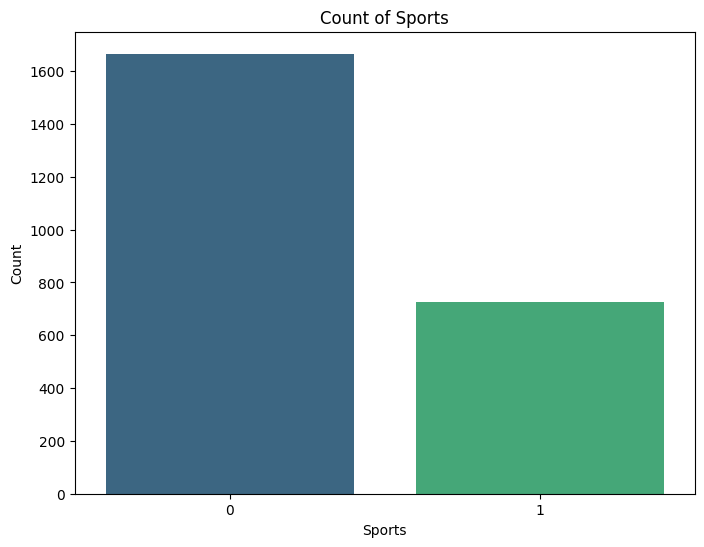

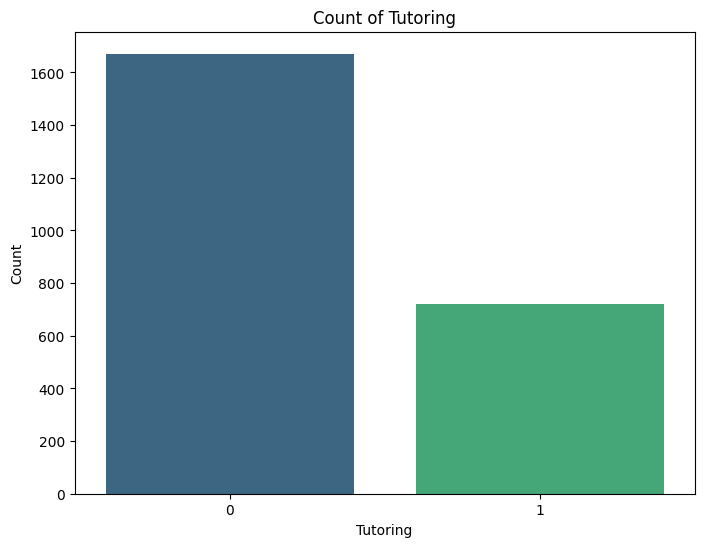

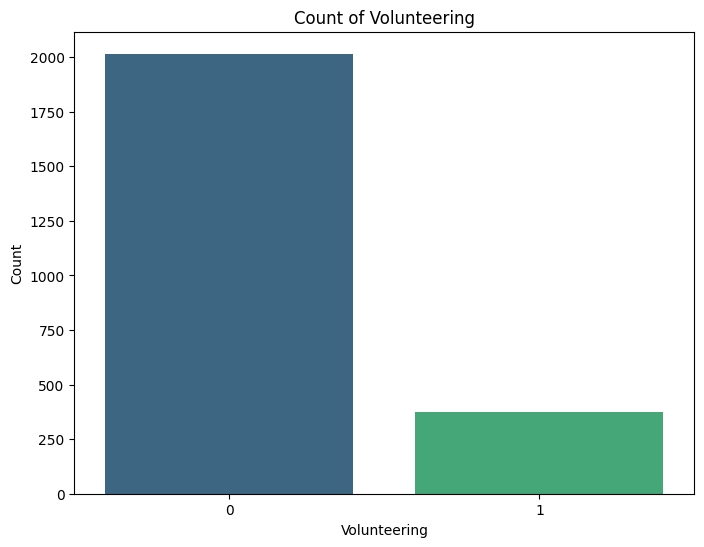

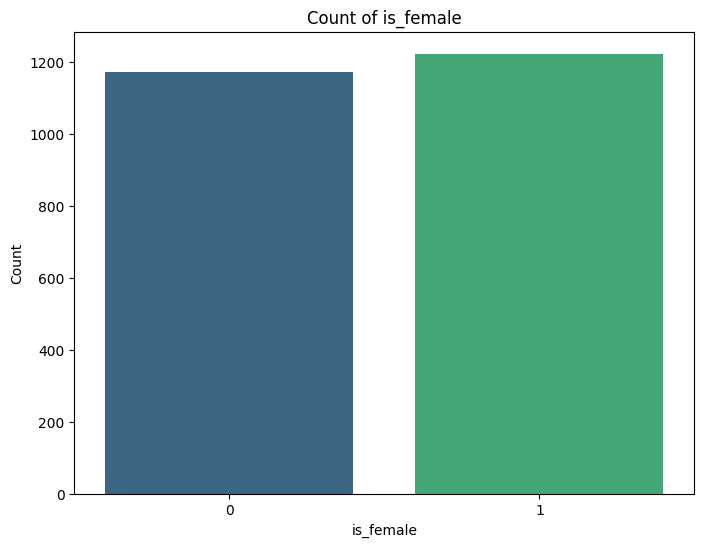

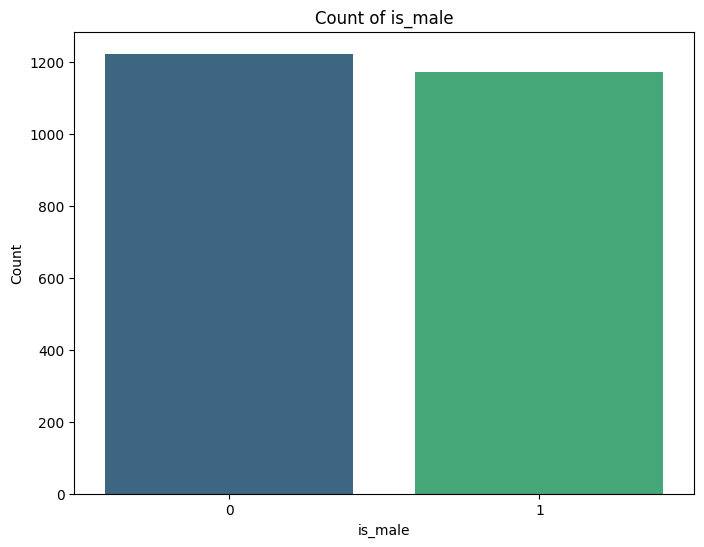

In [12]:
more_continues_cols=['StudyTimeWeekly','Absences']
other_cols= df.columns.difference(more_continues_cols)
for column in other_cols:
    category_counts = df[column].value_counts().reset_index()
    category_counts.columns = [column, 'Count']

    # Plotting the bar chart with Seaborn
    plt.figure(figsize=(8, 6))
    sns.barplot(x=column, y='Count', data=category_counts, palette='viridis')
    plt.xlabel(column)
    plt.ylabel('Count')
    plt.title('Count of '+column)
    plt.savefig(f"{column}_hist.png")

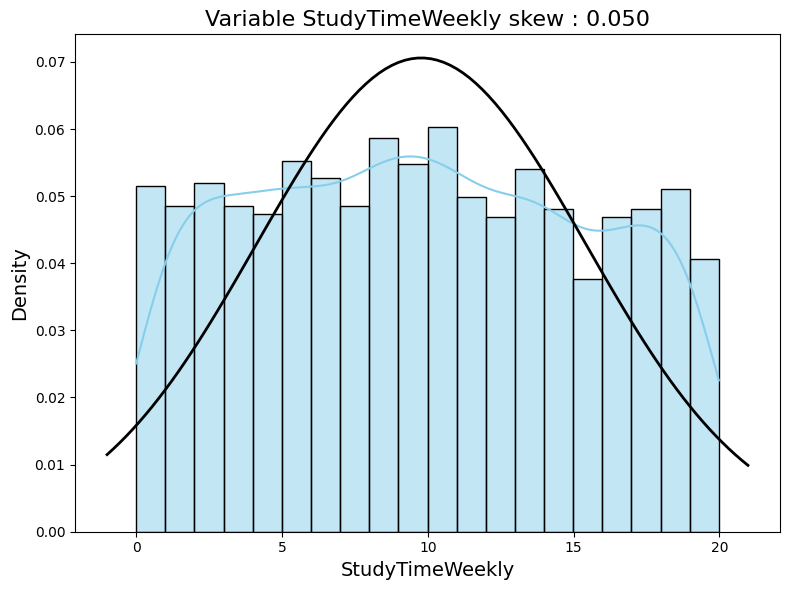

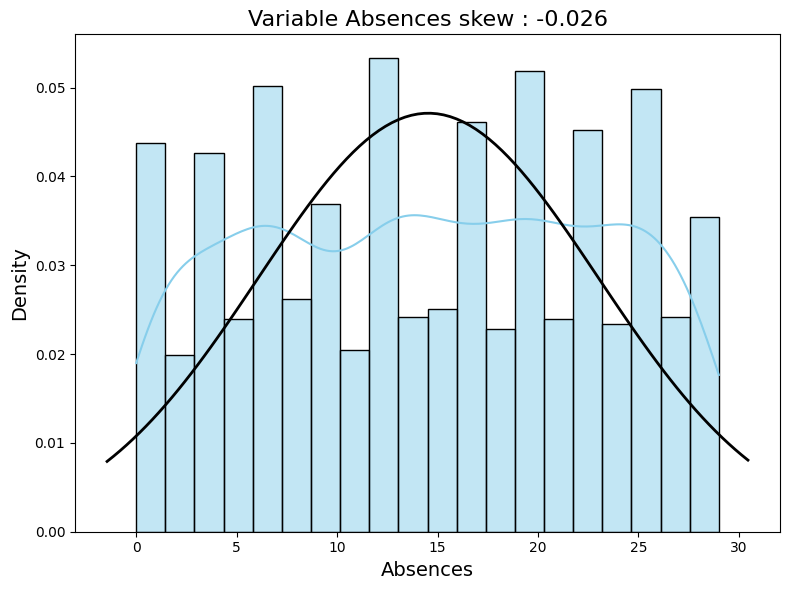

In [13]:
for col in more_continues_cols:
  data = df[col]

  # Calculate skewness of the data
  data_skew = skew(data)

  # Create the plot
  plt.figure(figsize=(8, 6))

  # Plot the histogram with a density plot (KDE)
  sns.histplot(data, kde=True, stat="density", color="skyblue", edgecolor="black", bins=20)

  # Fit a normal distribution and plot the PDF (Probability Density Function)
  xmin, xmax = plt.xlim()
  x = np.linspace(xmin, xmax, 100)
  p = norm.pdf(x, np.mean(data), np.std(data))
  plt.plot(x, p, 'k', linewidth=2)

  # Add skewness information to the title
  plt.title(f"Variable {col} skew : {data_skew:.3f}", fontsize=16)

  # Label axes
  plt.xlabel(col, fontsize=14)
  plt.ylabel("Density", fontsize=14)

  # Show plot
  plt.tight_layout()
  plt.savefig(f"{col}_hist.png")
  plt.show()

As we explained in the report, we will divide `GradeClass` target feature into 2 groups, failed(0) and passed(1).

In [14]:
df['GradeClass']= df['GradeClass'].apply(lambda x: 0 if x == 4 else 1)

We will create new histogram for the 'GradeClass'

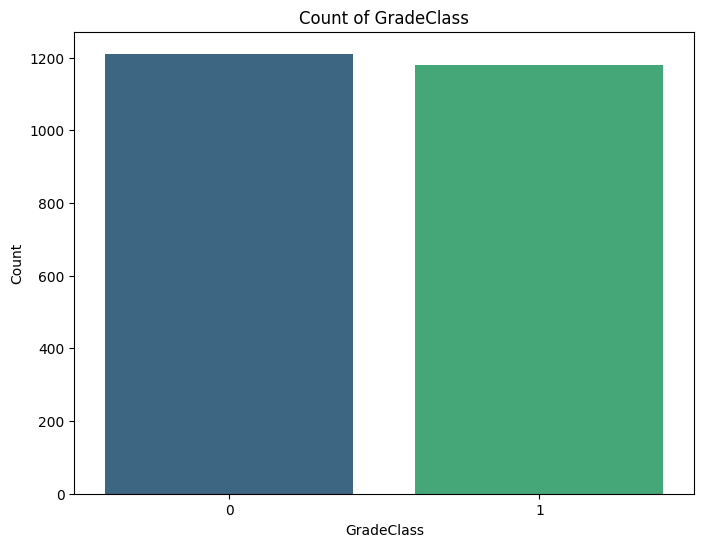

In [15]:
column= 'GradeClass'
category_counts = df[column].value_counts().reset_index()
category_counts.columns = [column, 'Count']

# Plotting the bar chart with Seaborn
plt.figure(figsize=(8, 6))
sns.barplot(x=column, y='Count', data=category_counts, palette='viridis')
plt.xlabel(column)
plt.ylabel('Count')
plt.title('Count of '+column)
plt.savefig("New_GradeClass_divided_hist.png")

Outliers

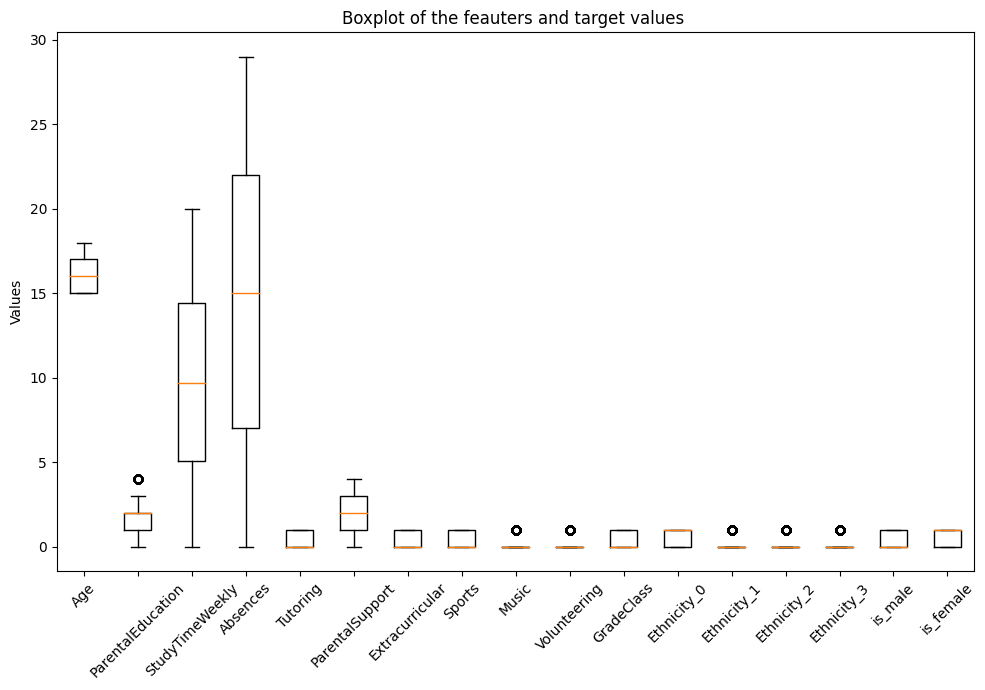

In [16]:
fig, ax = plt.subplots(figsize=(10, 7))
bp = ax.boxplot(df)
ax.set_xticklabels(df.columns, rotation=45)
ax.set_title('Boxplot of the feauters and target values ')
ax.set_ylabel('Values')
plt.tight_layout()
plt.savefig("outliers_boxplots.png")

We will check pearson correlation to see the correlation between each feature to another and the most important each feature to the label.    
We chose to calculate pearson correlation because the values themself ​​are important and not just their order, the spaces between each number have meaning.
Moreover, we checked for the signifcant correlaiton after applying FDR (p<0.05)

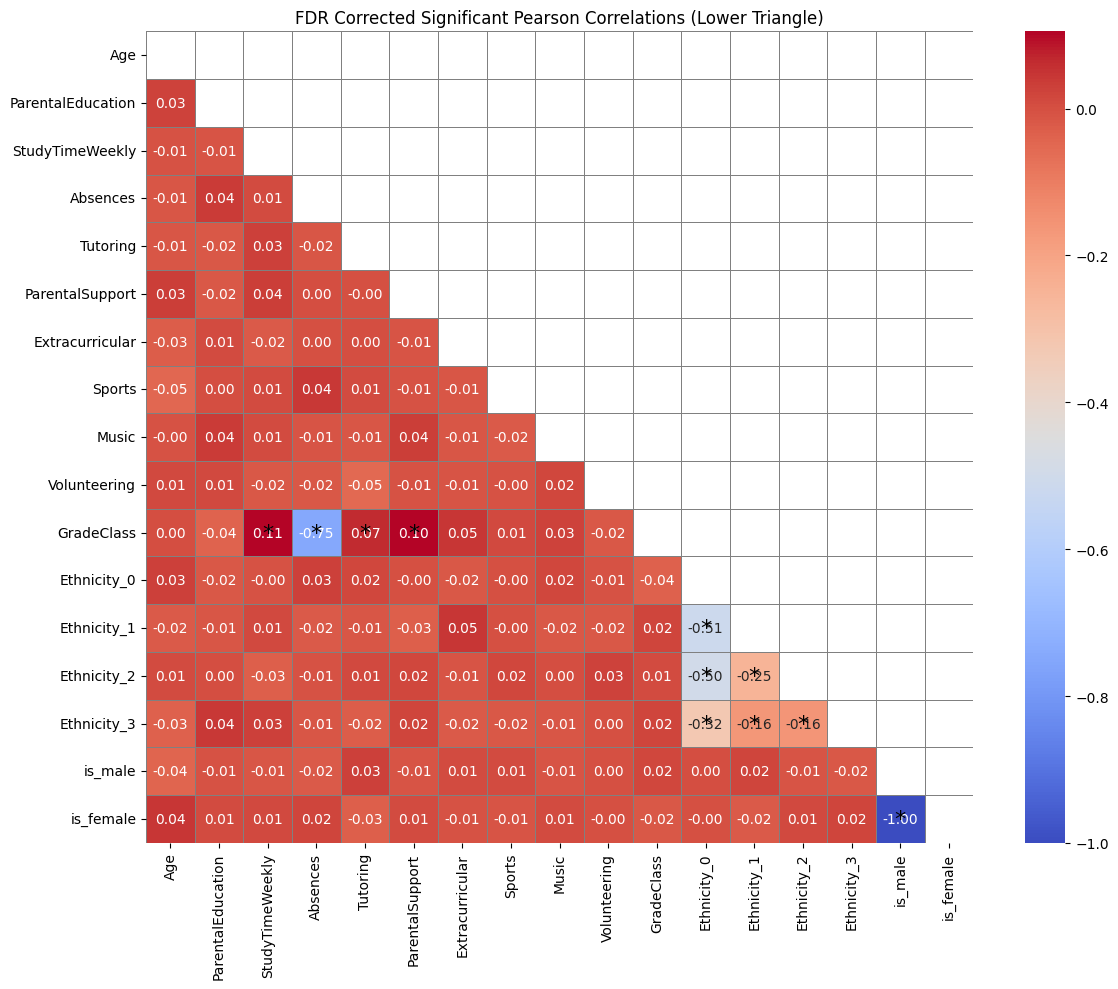

In [51]:
import pandas as pd
import numpy as np
from scipy.stats import pearsonr
from statsmodels.stats.multitest import fdrcorrection
import matplotlib.pyplot as plt
import seaborn as sns

# Function to calculate Pearson correlation and corresponding p-values
def calculate_pearson_pvalues(df):
    pvals = pd.DataFrame(np.ones((df.shape[1], df.shape[1])), columns=df.columns, index=df.columns)
    for i in range(df.shape[1]):
        for j in range(i+1, df.shape[1]):
            corr, pval = pearsonr(df.iloc[:, i], df.iloc[:, j])
            pvals.iloc[i, j] = pval
            pvals.iloc[j, i] = pval
    return pvals

# Assuming 'df' is your DataFrame
# Calculate Pearson correlation matrix
pearson_corr = df.corr(method='pearson')

# Calculate p-values for the correlations
p_values = calculate_pearson_pvalues(df)

# Apply FDR correction
pvals_flat = p_values.values.flatten()
_, pvals_corrected_flat = fdrcorrection(pvals_flat, alpha=0.05)
pvals_corrected = pvals_corrected_flat.reshape(p_values.shape)

# Create a boolean mask for significant p-values after FDR correction
significant_mask = pvals_corrected < 0.05

# Mask the upper triangle to keep only the lower triangle
mask = np.triu(np.ones_like(pearson_corr, dtype=bool))

# Plot the heatmap with the lower triangle of the correlation matrix
plt.figure(figsize=(12, 10))
sns.heatmap(pearson_corr, mask=mask, annot=True, cmap='coolwarm', fmt=".2f", linewidths=0.5, linecolor='gray')

# Add stars (*) for significant p-values in the lower triangle
for i in range(significant_mask.shape[0]):
    for j in range(i):
        if significant_mask[i, j]:  # Only for lower triangle
            plt.text(j + 0.5, i + 0.5, '*', fontsize=16, color='black', ha='center', va='center')

plt.title('FDR Corrected Significant Pearson Correlations (Lower Triangle)')
plt.tight_layout()
plt.savefig("Pearson_heatmap_with_FDR_correction.png")
plt.show()

#Statistical tests

## Kolomgrov Simrnov

In [19]:
for column in df.columns:
    data = df[column]
    # Perform K-S test
    ks_statistic, p_value = stats.kstest(data, 'norm')
    print(f"{column}: K-S statistic = {ks_statistic:.4f}, P-value = {p_value:.4f}")

    # Check the normality
    if p_value < 0.05:
        print(f"{column} is *not* normally distributed (reject H0)\n")
    else:
        print(f"{column} is normally distributed (fail to reject H0)\n")

Age: K-S statistic = 1.0000, P-value = 0.0000
Age is *not* normally distributed (reject H0)

ParentalEducation: K-S statistic = 0.7398, P-value = 0.0000
ParentalEducation is *not* normally distributed (reject H0)

StudyTimeWeekly: K-S statistic = 0.8787, P-value = 0.0000
StudyTimeWeekly is *not* normally distributed (reject H0)

Absences: K-S statistic = 0.9137, P-value = 0.0000
Absences is *not* normally distributed (reject H0)

Tutoring: K-S statistic = 0.5000, P-value = 0.0000
Tutoring is *not* normally distributed (reject H0)

ParentalSupport: K-S statistic = 0.7527, P-value = 0.0000
ParentalSupport is *not* normally distributed (reject H0)

Extracurricular: K-S statistic = 0.5000, P-value = 0.0000
Extracurricular is *not* normally distributed (reject H0)

Sports: K-S statistic = 0.5000, P-value = 0.0000
Sports is *not* normally distributed (reject H0)

Music: K-S statistic = 0.5000, P-value = 0.0000
Music is *not* normally distributed (reject H0)

Volunteering: K-S statistic = 0.5

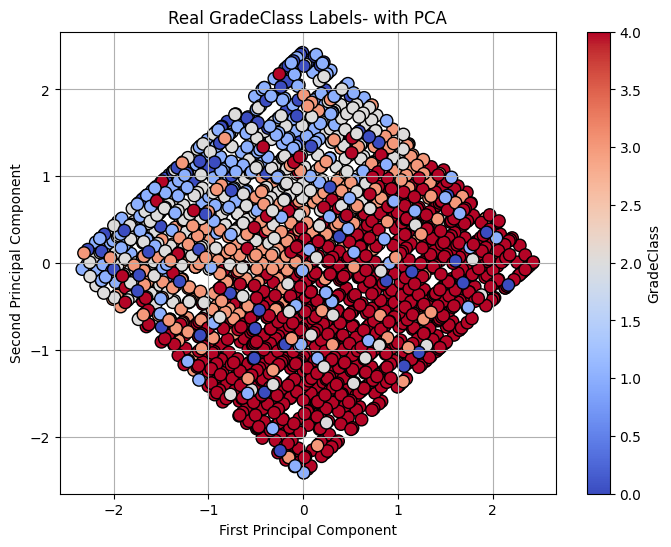

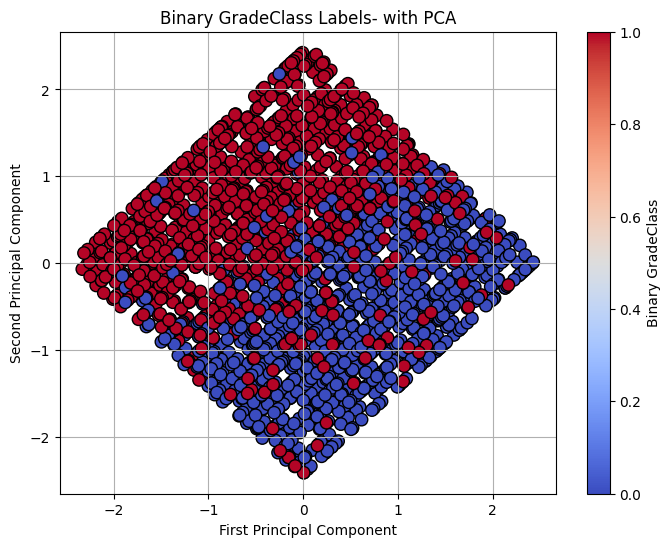

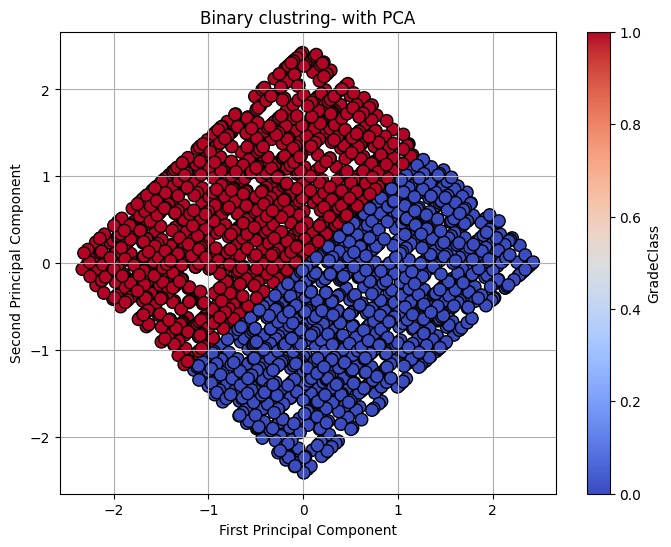

In [20]:
# took the top 2 lowest p value of man whiteny test ( most significant)
# pca 0-5 label
# pca 0-1 label
# kmeans (0-1)
X = df_original[['StudyTimeWeekly', 'Absences']]
y_real_5 = df_original['GradeClass']
y_real_binary= df['GradeClass']

scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)



#Apply PCA for dimensionality reduction (2D)
pca = PCA(n_components=2)
X_pca = pca.fit_transform(X_scaled)

plt.figure(figsize=(8, 6))
plt.scatter(X_pca[:, 0], X_pca[:, 1], c=y_real_5, cmap='coolwarm', edgecolor='k', s=80)
plt.title('Real GradeClass Labels- with PCA')
plt.xlabel('First Principal Component')
plt.ylabel('Second Principal Component')
plt.colorbar(label='GradeClass')
plt.grid(True)
plt.show()

# binary

plt.figure(figsize=(8, 6))
plt.scatter(X_pca[:, 0], X_pca[:, 1], c=y_real_binary, cmap='coolwarm', edgecolor='k', s=80)
plt.title('Binary GradeClass Labels- with PCA')
plt.xlabel('First Principal Component')
plt.ylabel('Second Principal Component')
plt.colorbar(label='Binary GradeClass')
plt.grid(True)
plt.show()

#Apply K-means clustering
kmeans = KMeans(n_clusters=2)
kmeans.fit(X_scaled)
labels = kmeans.labels_

plt.figure(figsize=(8, 6))
plt.scatter(X_pca[:, 0], X_pca[:, 1], c=labels, cmap='coolwarm', edgecolor='k', s=80)
plt.title('Binary clustring- with PCA')
plt.xlabel('First Principal Component')
plt.ylabel('Second Principal Component')
plt.colorbar(label='GradeClass')
plt.grid(True)
plt.show()




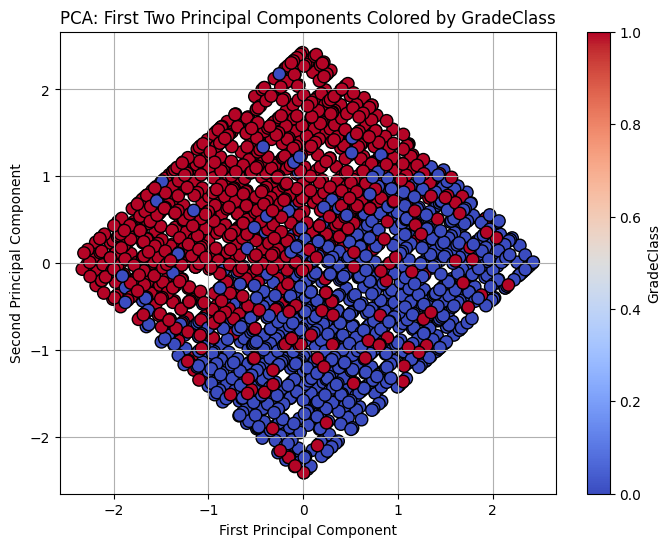

In [21]:
# Plot the true labels (pass/fail) without clustering
plt.figure(figsize=(8, 6))
plt.scatter(X_pca[:, 0], X_pca[:, 1], c=df['GradeClass'], cmap='coolwarm', edgecolor='k', s=80)
plt.title('PCA: First Two Principal Components Colored by GradeClass')
plt.xlabel('First Principal Component')
plt.ylabel('Second Principal Component')
plt.colorbar(label='GradeClass')
plt.grid(True)
plt.show()


Due to the fact that the data is not normally distributed, we will use a parametric tests to analyze the data.

## Two Sided- Mann whitney Test

Is Parental support affected by ParentalEducation?



In [22]:
p_values = []
levels_tested = []

# Iterate over the unique levels of ParentalSupport
for level in df['ParentalSupport'].unique():
    print(f"For ParentalSupport level {level}")

    # Summing the one-hot encoded Ethnicity columns for the current level of ParentalSupport
    df_parental = df[df['ParentalEducation'] == level]['ParentalSupport']
    # Summing the one-hot encoded Ethnicity columns for all other levels of ParentalSupport
    df_not_including_level_parental = df[df['ParentalEducation'] != level]['ParentalSupport']

    # Display the hypotheses
    print(f"HO: The distribution of Ethnicity between students who got {level} parental support and the group of all students, is the same.")
    print(f"H1: The distribution of Ethnicity between students who got {level} parental support and the group of all students, is *not* the same.")
    print()


    # Perform the Mann-Whitney U test for each Ethnicity column (individually compare distributions)
    u_statistic, p_value = mannwhitneyu(df_parental, df_not_including_level_parental, alternative='two-sided')

    # Store the p-value and level for FDR correction
    p_values.append(p_value)
    levels_tested.append(level)


    print(f'U statistic: {u_statistic}')
    print(f'P-value (before FDR): {p_value}')
    print()

# Perform FDR correction using the Benjamini-Hochberg method
rejected, pvals_corrected, _, _ = multipletests(p_values, alpha=0.05, method='fdr_bh')

# Print the results after FDR correction
for i in range(len(levels_tested)):
    print(f"For ParentalSupport level {levels_tested[i]}:")
    print(f"P-value after FDR correction: {pvals_corrected[i]}")

    if rejected[i]:
        print("Reject H0")
    else:
        print("Failed to reject H0")

    print()

For ParentalSupport level 2
HO: The distribution of Ethnicity between students who got 2 parental support and the group of all students, is the same.
H1: The distribution of Ethnicity between students who got 2 parental support and the group of all students, is *not* the same.

U statistic: 694140.0
P-value (before FDR): 0.40560482962767164

For ParentalSupport level 1
HO: The distribution of Ethnicity between students who got 1 parental support and the group of all students, is the same.
H1: The distribution of Ethnicity between students who got 1 parental support and the group of all students, is *not* the same.

U statistic: 625009.0
P-value (before FDR): 0.198836950702439

For ParentalSupport level 3
HO: The distribution of Ethnicity between students who got 3 parental support and the group of all students, is the same.
H1: The distribution of Ethnicity between students who got 3 parental support and the group of all students, is *not* the same.

U statistic: 357554.0
P-value (befo

Are there feaures that distributed different between students who passed or failed?

In [23]:
cols_withouttarget= df.columns.difference(['GradeClass'])
# Initialize lists to store p-values and columns for FDR correction
p_values = []
columns_tested = []

# Iterate through each column excluding the target 'GradeClass'
for column in cols_withouttarget:
    # Separate the data into two groups based on 'GradeClass'
    completed = df[df['GradeClass'] == 1][column]
    not_completed = df[df['GradeClass'] == 0][column]

    print(f"H_0: The distribution of {column} between students who passed the high-school exams and those who failed is the same.")
    print(f"H_1: The distribution of {column} between students who passed the high-school exams and those who failed is not the same.")

    # Perform the Mann-Whitney U test
    u_statistic, p_value = mannwhitneyu(completed, not_completed, alternative='two-sided')

    # Store the p-value and column for later FDR correction
    p_values.append(p_value)
    columns_tested.append(column)

    print(f'U statistic: {u_statistic}')
    print(f'P-value (before FDR): {p_value}')
    print()

# Perform FDR correction using the Benjamini-Hochberg method
rejected, pvals_corrected, _, _ = multipletests(p_values, alpha=0.05, method='fdr_bh')

# Print the results after FDR correction
for i in range(len(columns_tested)):
    print(f"For column {columns_tested[i]}:")
    print(f"P-value after FDR correction: {pvals_corrected[i]}")

    if rejected[i]:
        print("Reject H0")
    else:
        print("Failed to reject H0")

    print()

H_0: The distribution of Absences between students who passed the high-school exams and those who failed is the same.
H_1: The distribution of Absences between students who passed the high-school exams and those who failed is not the same.
U statistic: 97954.5
P-value (before FDR): 1.0523991387892296e-292

H_0: The distribution of Age between students who passed the high-school exams and those who failed is the same.
H_1: The distribution of Age between students who passed the high-school exams and those who failed is not the same.
U statistic: 719048.5
P-value (before FDR): 0.8089800378210402

H_0: The distribution of Ethnicity_0 between students who passed the high-school exams and those who failed is the same.
H_1: The distribution of Ethnicity_0 between students who passed the high-school exams and those who failed is not the same.
U statistic: 690062.0
P-value (before FDR): 0.08695545554223055

H_0: The distribution of Ethnicity_1 between students who passed the high-school exams 

In [24]:
cols_withouttarget= df_original.columns.difference(['GradeClass'])
# Initialize lists to store p-values and columns for FDR correction
p_values = []
columns_tested = []

# Iterate through each column excluding the target 'GradeClass'
for column in cols_withouttarget:
    # Separate the data into two groups based on 'GradeClass'
    completed = df_original[df_original['GradeClass'] == 1][column]
    not_completed = df[df['GradeClass'] == 0][column]

    print(f"H_0: The distribution of {column} between students who passed the high-school exams and those who failed is the same.")
    print(f"H_1: The distribution of {column} between students who passed the high-school exams and those who failed is not the same.")

    # Perform the Mann-Whitney U test
    u_statistic, p_value = mannwhitneyu(completed, not_completed, alternative='two-sided')

    # Store the p-value and column for later FDR correction
    p_values.append(p_value)
    columns_tested.append(column)

    print(f'U statistic: {u_statistic}')
    print(f'P-value (before FDR): {p_value}')
    print()

# Perform FDR correction using the Benjamini-Hochberg method
rejected, pvals_corrected, _, _ = multipletests(p_values, alpha=0.05, method='fdr_bh')

# Print the results after FDR correction
for i in range(len(columns_tested)):
    print(f"For column {columns_tested[i]}:")
    print(f"P-value after FDR correction: {pvals_corrected[i]}")

    if rejected[i]:
        print("Reject H0")
    else:
        print("Failed to reject H0")

    print()

H_0: The distribution of Absences between students who passed the high-school exams and those who failed is the same.
H_1: The distribution of Absences between students who passed the high-school exams and those who failed is not the same.
U statistic: 16323.5
P-value (before FDR): 1.993940253963339e-118

H_0: The distribution of Age between students who passed the high-school exams and those who failed is the same.
H_1: The distribution of Age between students who passed the high-school exams and those who failed is not the same.
U statistic: 162729.5
P-value (before FDR): 0.9805675132293709

H_0: The distribution of Ethnicity_0 between students who passed the high-school exams and those who failed is the same.
H_1: The distribution of Ethnicity_0 between students who passed the high-school exams and those who failed is not the same.
U statistic: 160223.5
P-value (before FDR): 0.628428412032659

H_0: The distribution of Ethnicity_1 between students who passed the high-school exams and

## Chi Sqaure Test

### Contingency Table

In [25]:
# Initialize an empty list to store p-values from all the tests
p_values = []

# List to track which column the p-value corresponds to
columns_tested = []

# Perform Chi-Square test for each column in cols_withouttarget
for column in cols_withouttarget:
    # Create a contingency table
    contingency_table = pd.crosstab(df[column], df['GradeClass'])

    # Check the minimum value in the contingency table
    min_frequency = contingency_table.values.min()

    if min_frequency >= 5:
        print("H_0: There is no association between ", column, " and GradeClass")
        print("H_1: There is an association between ", column, " and GradeClass")

        # Perform the Chi-Square test
        chi2, p, dof, expected = chi2_contingency(contingency_table)

        # Store the p-value and column for later FDR correction
        p_values.append(p)
        columns_tested.append(column)

        print(f'Chi2 statistic: {chi2}')
        print()

# Perform FDR correction using the Benjamini-Hochberg method
rejected, pvals_corrected, _, _ = multipletests(p_values, alpha=0.05, method='fdr_bh')

# Print the results after FDR correction
for i in range(len(columns_tested)):
    print(f"For column {columns_tested[i]}:")
    print(f"P-value after FDR correction: {pvals_corrected[i]}")

    if rejected[i]:
        print("Reject H0")
    else:
        print("Failed to reject H0")

    print()

H_0: There is no association between  Age  and GradeClass
H_1: There is an association between  Age  and GradeClass
Chi2 statistic: 2.4309367007621456

H_0: There is no association between  Ethnicity_0  and GradeClass
H_1: There is an association between  Ethnicity_0  and GradeClass
Chi2 statistic: 2.7928265564624226

H_0: There is no association between  Ethnicity_1  and GradeClass
H_1: There is an association between  Ethnicity_1  and GradeClass
Chi2 statistic: 0.844877918173456

H_0: There is no association between  Ethnicity_2  and GradeClass
H_1: There is an association between  Ethnicity_2  and GradeClass
Chi2 statistic: 0.12589328159516608

H_0: There is no association between  Ethnicity_3  and GradeClass
H_1: There is an association between  Ethnicity_3  and GradeClass
Chi2 statistic: 0.9435936666801932

H_0: There is no association between  Extracurricular  and GradeClass
H_1: There is an association between  Extracurricular  and GradeClass
Chi2 statistic: 4.6913377160051795



### Goodness Of Fit

One Way Test

In [26]:
ethnicity_columns = [col for col in df.columns if 'Ethnicity_' in col]
df_course = df[ethnicity_columns].sum()

# Print hypotheses
print("HO: The Ethnicity is distributed uniformly across all categories.")
print("H1: The Ethnicity is not distributed uniformly across all categories.\n")

# Perform chi-square goodness-of-fit test
chi2_stat, p_value = stats.chisquare(df_course)

print("Chi-square statistic:", chi2_stat)
print("P-value:", p_value)

if p_value < 0.05:
    print("Reject H0.")
else:
    print("Failed to reject H0.")

HO: The Ethnicity is distributed uniformly across all categories.
H1: The Ethnicity is not distributed uniformly across all categories.

Chi-square statistic: 902.4515050167224
P-value: 2.6018247012104804e-195
Reject H0.


# Models

## Logistic regression

Cross-validation scores: [0.94363257 0.96033403 0.94142259 0.93514644 0.72384937]
Mean cross-validation score: 0.900877001423817
AUC: 0.9478086258075781
Accuracy: 0.8977035490605428


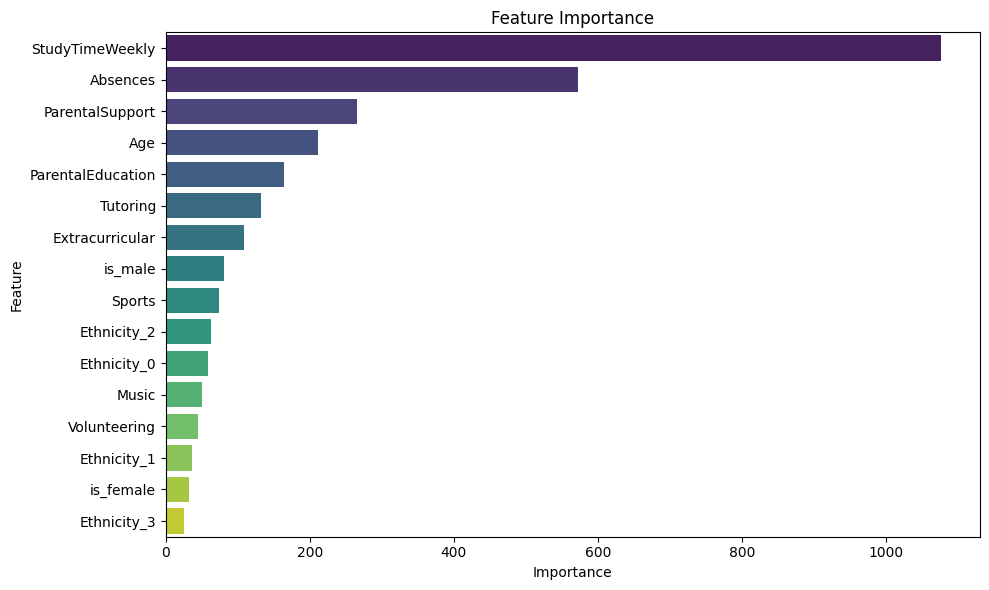

In [96]:
from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score, roc_auc_score

X = df.drop(columns='GradeClass')
y = df['GradeClass']

# Split the data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2)

# Train the model
model = LogisticRegression()
cv_scores = cross_val_score(model, X, y, cv=5)

# Print cross-validation scores
print(f'Cross-validation scores: {cv_scores}')
print(f'Mean cross-validation score: {cv_scores.mean()}')

# Fit the model on the training set
model.fit(X_train, y_train)

# Make predictions on the test set
y_pred = model.predict(X_test)
y_pred_proba = model.predict_proba(X_test)[:, 1]  # We take probabilities for the positive class (1)
auc = roc_auc_score(y_test, y_pred_proba)
print(f'AUC: {auc}')
# Evaluate the model
accuracy = accuracy_score(y_test, y_pred)
print(f'Accuracy: {accuracy}')

coefficients = model.coef_[0]
features = X.columns
importance = pd.DataFrame({'Feature': features, 'Coefficient': coefficients})
importance['AbsCoefficient'] = np.abs(importance['Coefficient'])
importance = importance.sort_values(by='AbsCoefficient', ascending=False)

plt.figure(figsize=(10, 6))
sns.barplot(x='Importance', y='Feature', data=importance_df, palette='viridis')

# Add labels and title
plt.title('Feature Importance')
plt.xlabel('Importance')
plt.ylabel('Feature')

# Display the plot
plt.tight_layout()
plt.savefig("logistic_importance.png")
plt.show()

Shap 'beeswarm' plot on the Train set


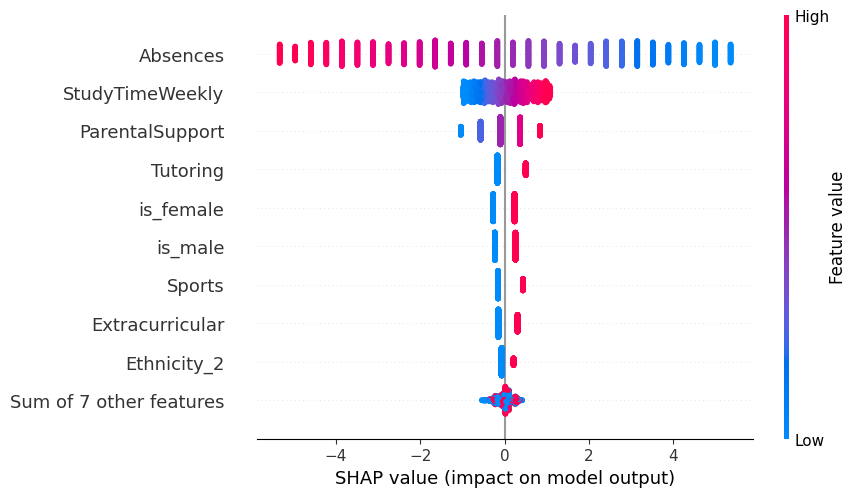

Shap 'beeswarm' plot on the Test set


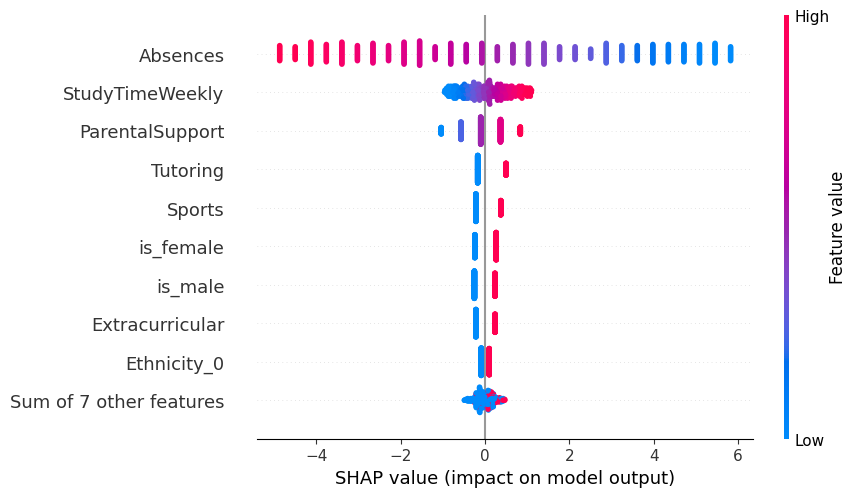

In [89]:
print("Shap 'beeswarm' plot on the Train set")
explainer = shap.Explainer(model, X_train)
shap_values = explainer(X_train)
shap.plots.beeswarm(shap_values)

print("Shap 'beeswarm' plot on the Test set")
explainer = shap.Explainer(model, X_test)
shap_values = explainer(X_test)
shap.plots.beeswarm(shap_values)

Cross-validation scores: [0.91231733 0.93319415 0.91841004 0.91631799 0.71338912]
Mean cross-validation score: 0.8787257274132825
AUC: 0.9510389383621443
Accuracy: 0.8893528183716075


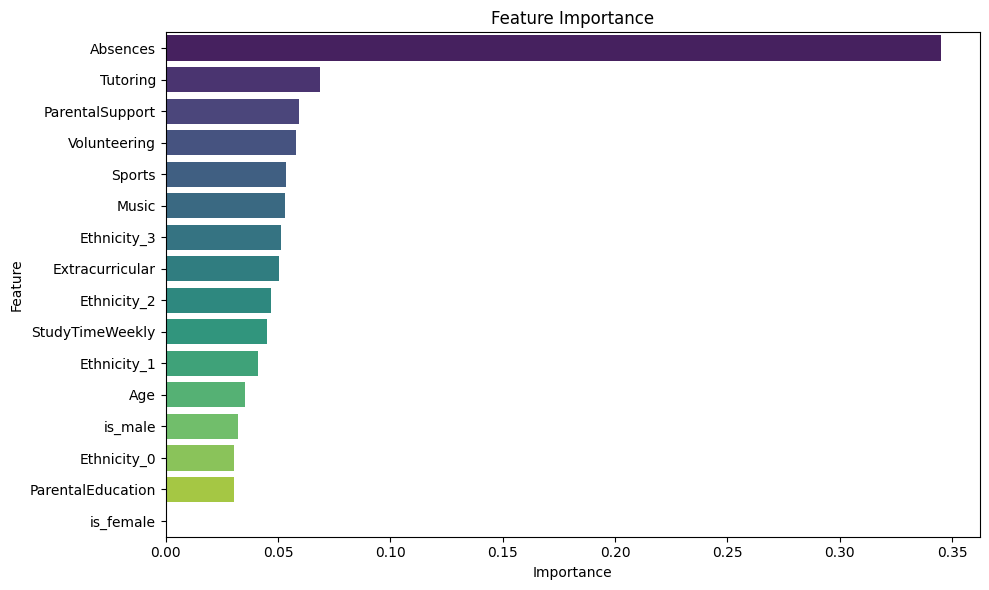

In [93]:
from xgboost import XGBClassifier

# Assuming df is your DataFrame
X = df.drop(columns='GradeClass')
y = df['GradeClass']

# Split the data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2)

# Train the XGBoost model
model = XGBClassifier(use_label_encoder=False, eval_metric='logloss')
cv_scores = cross_val_score(model, X, y, cv=5)

# Print cross-validation scores
print(f'Cross-validation scores: {cv_scores}')
print(f'Mean cross-validation score: {cv_scores.mean()}')

# Fit the model on the training set
model.fit(X_train, y_train)

# Make predictions on the test set
y_pred = model.predict(X_test)
y_pred_proba = model.predict_proba(X_test)[:, 1]  # We take probabilities for the positive class (1)
auc = roc_auc_score(y_test, y_pred_proba)
print(f'AUC: {auc}')
# Evaluate the model
accuracy = accuracy_score(y_test, y_pred)
print(f'Accuracy: {accuracy}')

# Feature importance
importance = model.feature_importances_
features = X.columns
importance_df = pd.DataFrame({'Feature': features, 'Importance': importance})
importance_df = importance_df.sort_values(by='Importance', ascending=False)

plt.figure(figsize=(10, 6))
sns.barplot(x='Importance', y='Feature', data=importance_df, palette='viridis')

# Add labels and title
plt.title('Feature Importance')
plt.xlabel('Importance')
plt.ylabel('Feature')

# Display the plot
plt.tight_layout()
plt.savefig("xgb_importance")
plt.show()

Shap 'beeswarm' plot on the Train set


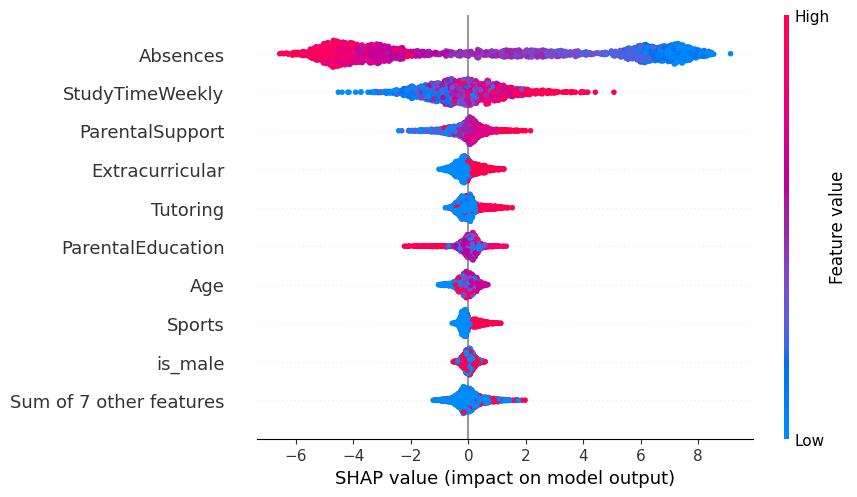

Shap 'beeswarm' plot on the Test set


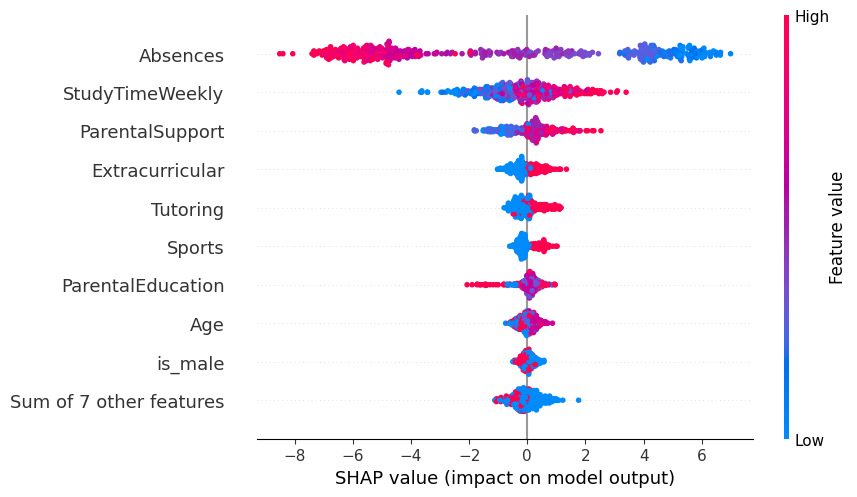

In [91]:
print("Shap 'beeswarm' plot on the Train set")
explainer = shap.Explainer(model, X_train)
shap_values = explainer(X_train)
shap.plots.beeswarm(shap_values)

print("Shap 'beeswarm' plot on the Test set")
explainer = shap.Explainer(model, X_test)
shap_values = explainer(X_test)
shap.plots.beeswarm(shap_values)

[LightGBM] [Info] Number of positive: 944, number of negative: 969
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000454 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 322
[LightGBM] [Info] Number of data points in the train set: 1913, number of used features: 16
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.493466 -> initscore=-0.026138
[LightGBM] [Info] Start training from score -0.026138
[LightGBM] [Info] Number of positive: 945, number of negative: 968
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000427 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 322
[LightGBM] [Info] Number of data points in the train set: 1913, number of used features: 16
[LightGBM] [Info] [binary:Boos

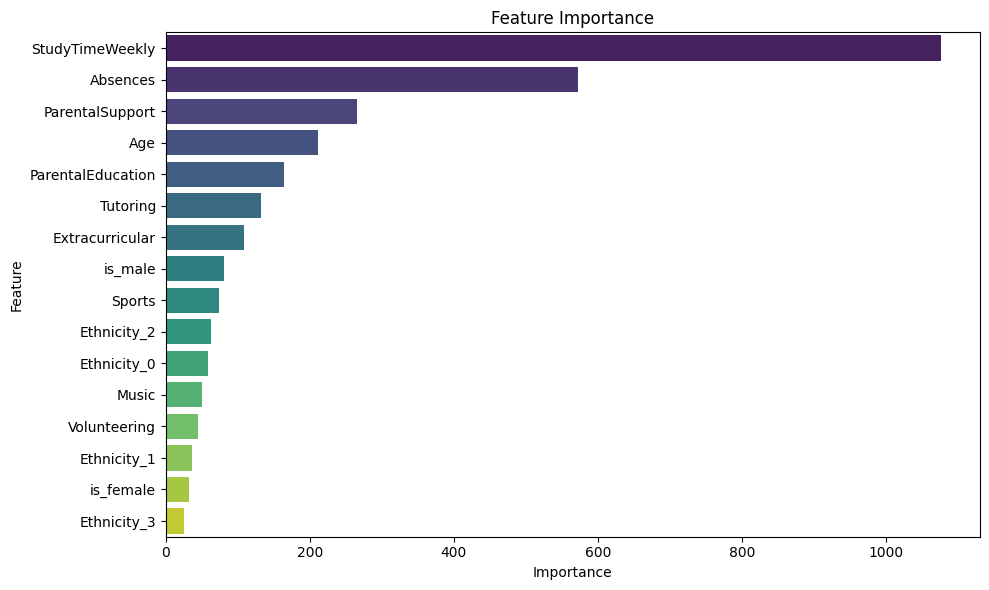

In [94]:
from lightgbm import LGBMClassifier

# Assuming df is your DataFrame
X = df.drop(columns='GradeClass')
y = df['GradeClass']

# Split the data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2)

# Train the LightGBM model
model = LGBMClassifier()
cv_scores = cross_val_score(model, X, y, cv=5)

# Print cross-validation scores
print(f'Cross-validation scores: {cv_scores}')
print(f'Mean cross-validation score: {cv_scores.mean()}')

# Fit the model on the training set
model.fit(X_train, y_train)

# Make predictions on the test set
y_pred = model.predict(X_test)
y_pred_proba = model.predict_proba(X_test)[:, 1]  # We take probabilities for the positive class (1)
auc = roc_auc_score(y_test, y_pred_proba)
print(f'AUC: {auc}')
# Evaluate the model
accuracy = accuracy_score(y_test, y_pred)
print(f'Accuracy: {accuracy}')

# Feature importance
importance = model.feature_importances_
features = X.columns
importance_df = pd.DataFrame({'Feature': features, 'Importance': importance})
importance_df = importance_df.sort_values(by='Importance', ascending=False)

plt.figure(figsize=(10, 6))
sns.barplot(x='Importance', y='Feature', data=importance_df, palette='viridis')

# Add labels and title
plt.title('Feature Importance')
plt.xlabel('Importance')
plt.ylabel('Feature')

# Display the plot
plt.tight_layout()
plt.savefig("lgbm_importance")
plt.show()

Shap 'beeswarm' plot on the Train set


 97%|=================== | 1856/1913 [00:19<00:00]       

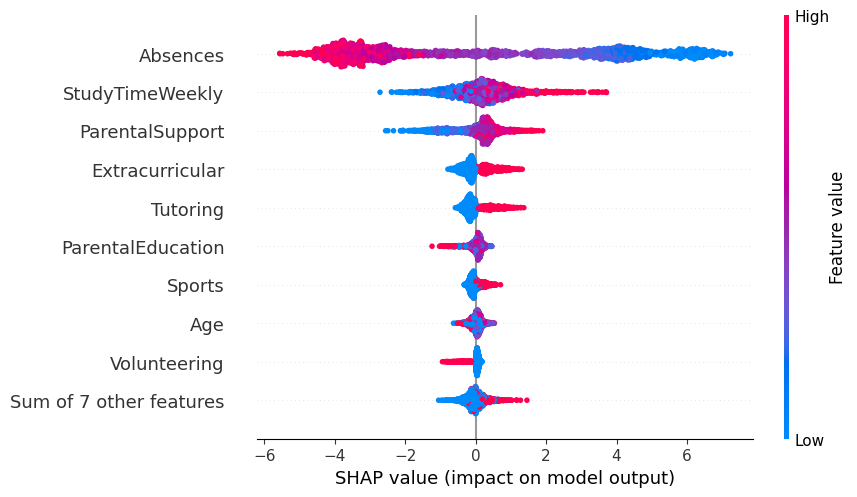

Shap 'beeswarm' plot on the Test set


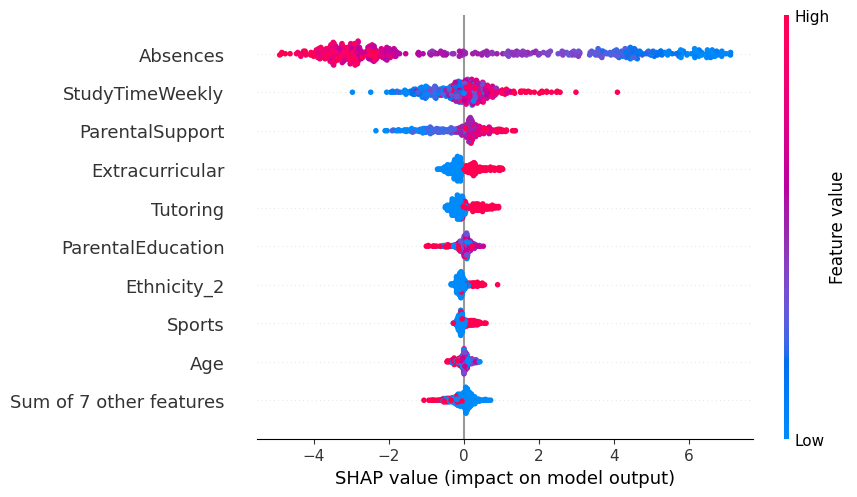

In [86]:
print("Shap 'beeswarm' plot on the Train set")
explainer = shap.Explainer(model, X_train)
shap_values = explainer(X_train)
shap.plots.beeswarm(shap_values)

print("Shap 'beeswarm' plot on the Test set")
explainer = shap.Explainer(model, X_test)
shap_values = explainer(X_test)
shap.plots.beeswarm(shap_values)